In [1]:
import os
# Set TensorFlow logging level BEFORE importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, callbacks

import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Optional: Further suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

# Load CSVs
df_1and2 = pd.read_csv('burns_1and2.csv')
df_3 = pd.read_csv('burns_3rd.csv')

# Assign labels: 0 = 1st/2nd degree (urgent care), 1 = 3rd degree (ER)
df_1and2['binary_label'] = 0
df_3['binary_label'] = 1

# Combine
df_all = pd.concat([df_1and2, df_3], ignore_index=True)
print(df_all['binary_label'].value_counts())
print(df_all.sample(5))


# tf.debugging.set_log_device_placement(True)


2025-07-25 14:41:56.327832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753472516.336183   34342 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753472516.338599   34342 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753472516.345178   34342 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753472516.345187   34342 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753472516.345187   34342 computation_placer.cc:177] computation placer alr

binary_label
0    4876
1    1023
Name: count, dtype: int64
                                               filepath           label  \
5746  alt_burn_dataset/skin burn dataset/train/3nd d...      3rd_degree   
1978  alt_burn_dataset/skin burn dataset/train/1st d...  1_and_2_degree   
1760  alt_burn_dataset/skin burn dataset/train/1st d...  1_and_2_degree   
3768  alt_burn_dataset/skin burn dataset/train/2nd d...  1_and_2_degree   
5401  alt_burn_dataset/skin burn dataset/train/3nd d...      3rd_degree   

      binary_label  
5746             1  
1978             0  
1760             0  
3768             0  
5401             1  


In [2]:
train_df, val_df = train_test_split(
    df_all, test_size=0.2, stratify=df_all['binary_label'], random_state=42
)
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 4719
Validation samples: 1180


In [3]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights based training data
y_train = train_df['binary_label'].values
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

print("Class weights:", class_weights)


Class weights: {0: 0.6048449115611382, 1: 2.8844743276283618}


In [4]:
IMG_SIZE = (224, 224)  # Change  higher/lower res
BATCH_SIZE = 32

class BurnDataGenerator(Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        images = []
        labels = []
        for _, row in batch_df.iterrows():
            img = load_img(row['filepath'], target_size=self.img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(row['binary_label'])
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

            
# Instantiate the generators (AFTER split!)
train_gen = BurnDataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True)
val_gen = BurnDataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)


In [5]:
model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1753472517.509559   34342 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1009 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1753472517.510944   34342 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1005 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,  # This makes the model pay more attention to minority class!
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)



Epoch 1/30


/home/yeblad/anaconda3/envs/capstone_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753472518.540301   34471 service.cc:152] XLA service 0x74be24004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753472518.540325   34471 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1753472518.540327   34471 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1753472518.664356   34471 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/148 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3884 - loss: 0.8254

I0000 00:00:1753472520.094700   34471 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.6965 - loss: 0.6080 - val_accuracy: 0.8551 - val_loss: 0.3826
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7543 - loss: 0.5117 - val_accuracy: 0.6305 - val_loss: 0.6461
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7553 - loss: 0.4906 - val_accuracy: 0.8042 - val_loss: 0.4236
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7889 - loss: 0.4299 - val_accuracy: 0.8110 - val_loss: 0.4110


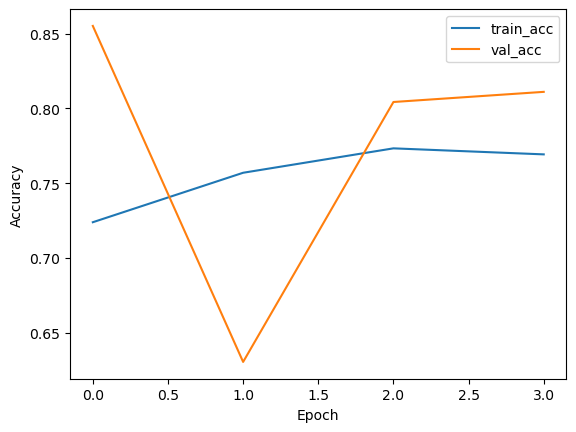

In [7]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
val_preds = model.predict(val_gen) > 0.5
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_df['binary_label'], val_preds.astype(int)))
print(confusion_matrix(val_df['binary_label'], val_preds.astype(int)))


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       975
           1       0.59      0.53      0.56       205

    accuracy                           0.86      1180
   macro avg       0.75      0.73      0.74      1180
weighted avg       0.85      0.86      0.85      1180

[[901  74]
 [ 97 108]]


In [9]:
model.save('burn_triage_cnn.h5')    # or




In [11]:
# Try a lower threshold to boost recall for class 1
for thresh in [0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    print(f"\n--- Results at threshold {thresh} ---")
    val_preds_thresh = (val_preds > thresh).astype(int).flatten()
    print(classification_report(val_df['binary_label'], val_preds_thresh))
    print(confusion_matrix(val_df['binary_label'], val_preds_thresh))


--- Results at threshold 0.8 ---
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       975
           1       0.59      0.53      0.56       205

    accuracy                           0.86      1180
   macro avg       0.75      0.73      0.74      1180
weighted avg       0.85      0.86      0.85      1180

[[901  74]
 [ 97 108]]

--- Results at threshold 0.7 ---
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       975
           1       0.59      0.53      0.56       205

    accuracy                           0.86      1180
   macro avg       0.75      0.73      0.74      1180
weighted avg       0.85      0.86      0.85      1180

[[901  74]
 [ 97 108]]

--- Results at threshold 0.6 ---
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       975
           1       0.59      0.53      0.56       205

    accuracy                      